In [120]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import GridSearchCV

### Read and impute data 

In [121]:
movies_df =pd.read_csv('data/ml-latest-small/movies.csv')
ratings_df =pd.read_csv('data/ml-latest-small/ratings.csv')
links_df =pd.read_csv('data/ml-latest-small/links.csv')
tags_df =pd.read_csv('data/ml-latest-small/tags.csv')
movies_df['year'] =movies_df.title.apply(lambda x: x [-5:-1] if  x[-5].strip() in ['1','2'] else None)
movie_rat_df = ratings_df.merge(movies_df)

#### movie most rated by title 
We want to do this analysis across all the dataset to later check our recommendation result. We want to check against the criteria that movies are recommended based on user prefrerence and not only  because of the prevalance of that that movie in dataset. 

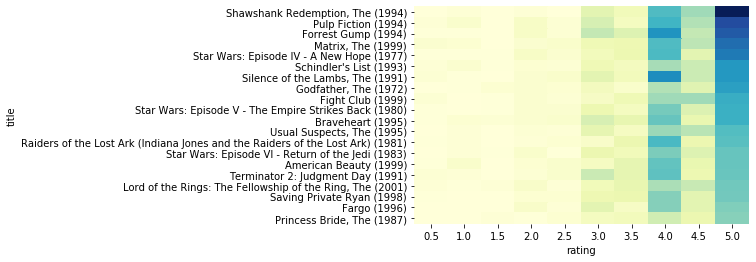

In [122]:
sns.heatmap(pd.crosstab(movie_rat_df.title, movie_rat_df.rating).sort_values(5.0, ascending= False).head(20), 
            cmap="YlGnBu", cbar=False)


In [123]:
movie_rat_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [124]:
movie_rat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
title        100836 non-null object
genres       100836 non-null object
year         100806 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 6.2+ MB


In [125]:
pd.crosstab(movie_rat_df.genres, movie_rat_df.rating).sort_values(5.0, ascending= False).head(20)

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
genres,,,,,,,,,,
Drama,44,99,49,287,295,1144,830,2055,593,895
Comedy,136,348,256,828,515,1614,854,1586,403,656
Crime|Drama,7,19,16,66,55,261,258,739,336,558
Drama|Romance,26,73,36,144,104,514,374,853,257,457
Action|Adventure|Sci-Fi,27,60,47,190,114,453,296,597,190,387
Comedy|Romance,66,126,93,338,304,953,513,978,221,375
Comedy|Drama|Romance,36,53,42,210,165,572,433,865,253,371
Comedy|Drama,20,68,43,209,161,585,369,851,222,323
Action|Drama|War,9,12,7,37,24,138,120,307,117,263


#### movie most rated by genres 

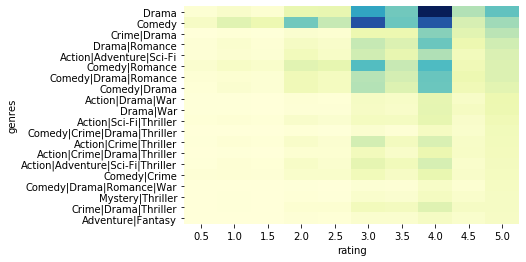

In [126]:
sns.heatmap(pd.crosstab(movie_rat_df.genres, movie_rat_df.rating).sort_values(5.0, ascending= False).head(20), 
            cmap="YlGnBu", cbar=False)

#### Prepare Data for modeling

One of the purpose of recommendation system is to predict   ratings by user to those items that are not rated by those users already. 
Surprise   module provides ways to create antiset of the  dataset. This set contains all those entries of ites for users which the user has not rated. We'll use this antiset to predict ratings values using our model for the user/item pairs that don't appear in original dataset.

In [127]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
anti_set = data.build_full_trainset().build_anti_testset()

### Create Basic kmean model 

In [128]:
kf = KFold(n_splits=3)
algo = KNNBasic()
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9524
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9585
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9603


#### make predictions on antiset based on above model 

In [129]:
predictions = algo.test(anti_set)
accuracy.rmse(predictions, verbose=True)

RMSE: 0.8278


0.8277880672288518

#### Merge predictions with detailed movie dataset .

In [130]:
pred_df = pd.DataFrame(predictions)
m_df = movies_df.merge(pred_df, left_on = 'movieId', right_on = 'iid')
m_df['est'] =m_df.est.apply(lambda x: (round(x*2))/2)

#### Analysis of predictions 

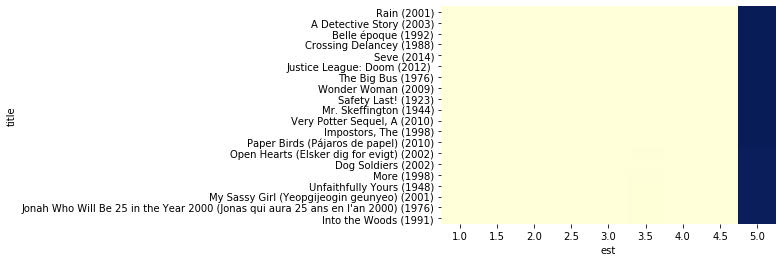

In [133]:
user_pred_df = pd.crosstab(m_df.year, m_df.est)
user_pred_df.sort_values(1.0, ascending = False).head()
sns.heatmap( user_pred_df.loc['1990':],  cbar=False)
sns.heatmap( pd.crosstab(m_df.title, m_df.est).sort_values(5.0, ascending = False).head(20),
            cmap="YlGnBu", cbar=False)

### Analysis with KNN with means

One of the problems with basic knn is that it treats missing ratings as negative rating for that movie if rating skale starts from avalue greater than and we are imputing missing values with zero. 
What we do in this case is to subtract raw mean for user in user item matrix to normalize the data.

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9001
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9032
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9045
RMSE: 0.7968


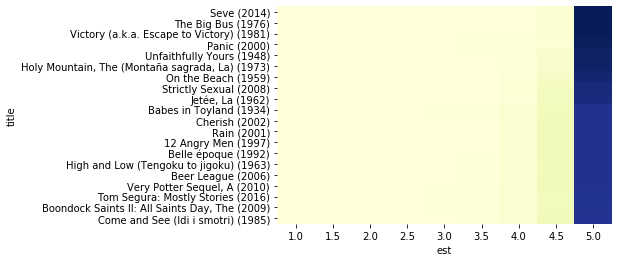

In [134]:
kf = KFold(n_splits=3)
algo = KNNWithMeans()
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
predictions = algo.test(anti_set)
accuracy.rmse(predictions, verbose=True)
pred_df = pd.DataFrame(predictions)
m_df = movies_df.merge(pred_df, left_on = 'movieId', right_on = 'iid')
m_df['est'] =m_df.est.apply(lambda x: (round(x*2))/2)
user_pred_df = pd.crosstab(m_df.year, m_df.est)
user_pred_df.sort_values(1.0, ascending = False).head()
sns.heatmap( user_pred_df.loc['1990':],  cbar=False)
sns.heatmap( pd.crosstab(m_df.title, m_df.est).sort_values(5.0, ascending = False).head(20),
            cmap="YlGnBu", cbar=False)

### Analysis with Knn baseline

KNN with baseline is used to handle the scenario where a new movie is added which is not rated yet. or when a new user is added who has not rated any movie . we use some baseline ratings in such cases. 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8864
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8795
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8813
RMSE: 0.7723


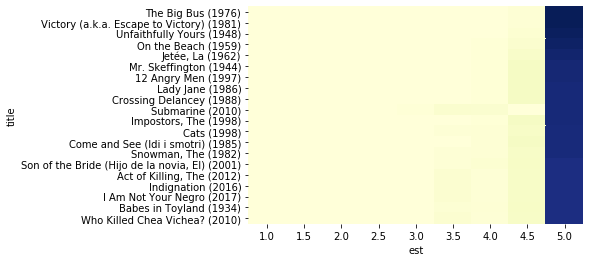

In [135]:
kf = KFold(n_splits=3)
algo = KNNBaseline()
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
predictions = algo.test(anti_set)
accuracy.rmse(predictions, verbose=True)
pred_df = pd.DataFrame(predictions)
m_df = movies_df.merge(pred_df, left_on = 'movieId', right_on = 'iid')
m_df['est'] =m_df.est.apply(lambda x: (round(x*2))/2)
user_pred_df.sort_values(1.0, ascending = False).head()
sns.heatmap( pd.crosstab(m_df.title, m_df.est).sort_values(5.0, ascending = False).head(20),
            cmap="YlGnBu", cbar=False)

In [136]:
#### Average Predicted ratings from year 1990

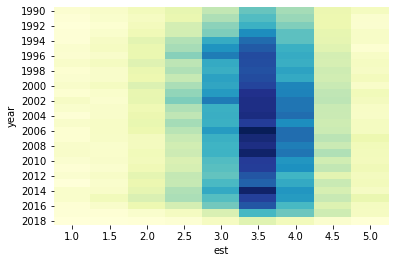

In [137]:
user_pred_df = pd.crosstab(m_df.year, m_df.est)
sns.heatmap( user_pred_df.loc['1990':],  cbar=False, cmap="YlGnBu")

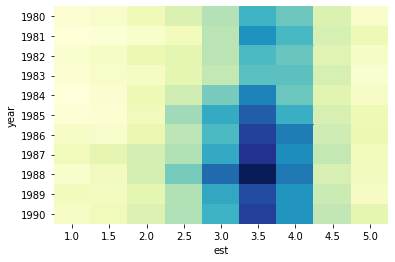

In [138]:
sns.heatmap( user_pred_df.loc['1980':'1990'],  cbar=False, cmap="YlGnBu")

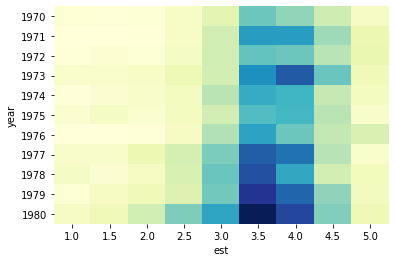

In [139]:
sns.heatmap( user_pred_df.loc['1970':'1980'],  cbar=False, cmap="YlGnBu")

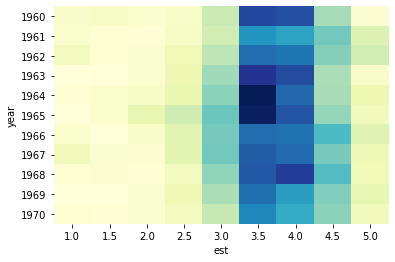

In [140]:
sns.heatmap( user_pred_df.loc['1960':'1970'],  cbar=False, cmap="YlGnBu")

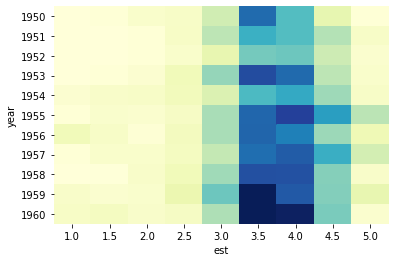

In [141]:
sns.heatmap( user_pred_df.loc['1950':'1960'],  cbar=False, cmap="YlGnBu")

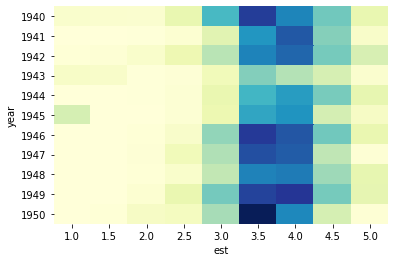

In [142]:
sns.heatmap( user_pred_df.loc['1940':'1950'],  cbar=False, cmap="YlGnBu")

### Analysis of individual user behaviour 

Some of the assumptions we are planning to address is whether sparisity of data has any impact. Are we going to  

In [143]:
movie_rat_uid_1=movie_rat_df[m_df.uid==1]
uid_1_actual_by_genre= pd.crosstab( movie_rat_uid_1.genres, movie_rat_uid_1.rating) 

/Users/pankaj/anaconda/envs/ML7331/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


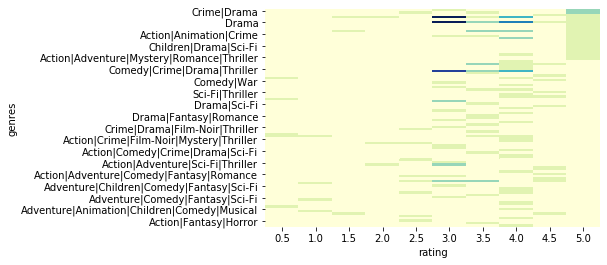

In [144]:
sns.heatmap(uid_1_actual_by_genre.sort_values(5.0, ascending = False), cbar=False, cmap="YlGnBu")

#### movies predicted for user 1 with by genres 

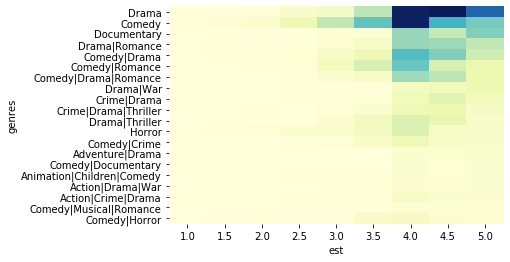

In [145]:
uid_1 = m_df[m_df.uid==1]
uid_1_rat5 = uid_1[uid_1.est==5.0]
sns.heatmap(pd.crosstab( uid_1.genres, uid_1.est).sort_values(5.0, ascending = False).head(20),
            cbar=False, cmap="YlGnBu")

#### for user 2 

/Users/pankaj/anaconda/envs/ML7331/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


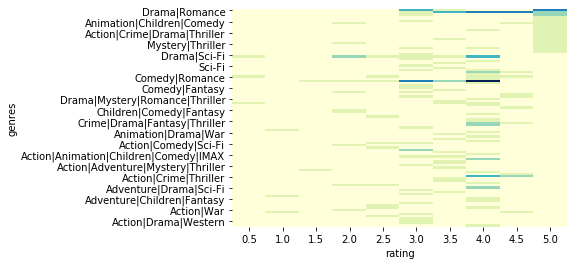

In [146]:
movie_rat_uid_2=movie_rat_df[m_df.uid==2]
sns.heatmap( pd.crosstab( movie_rat_uid_2.genres, movie_rat_uid_2.rating).sort_values(5.0, ascending = False)
            , cbar=False, cmap="YlGnBu")


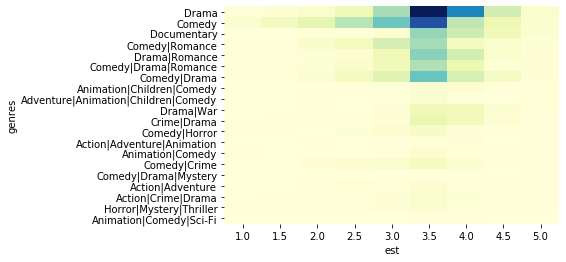

In [147]:
uid_2 = m_df[m_df.uid==2]
sns.heatmap(pd.crosstab( uid_2.genres, uid_2.est).sort_values(5.0, ascending = False).head(20),
            cbar=False, cmap="YlGnBu")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9065
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9037
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8991
RMSE: 0.5357


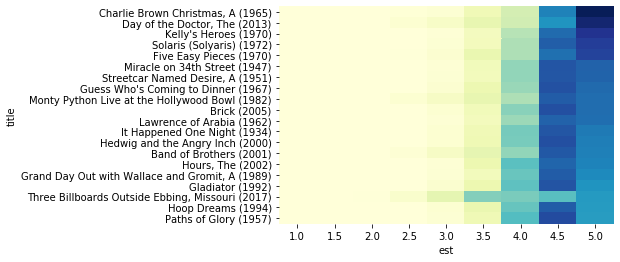

In [148]:
sim_options = {'name': 'cosine',
               'user_based': True}
bsl_options = {}

algo = KNNWithMeans(min_k =5,sim_options = sim_options, bsl_options= bsl_options)
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
predictions = algo.test(anti_set)
accuracy.rmse(predictions, verbose=True)
pred_df = pd.DataFrame(predictions)
m_df = movies_df.merge(pred_df, left_on = 'movieId', right_on = 'iid')
m_df['est'] =m_df.est.apply(lambda x: (round(x*2))/2)

sns.heatmap( pd.crosstab(m_df.title, m_df.est).sort_values(5.0, ascending = False).head(20),
            cmap="YlGnBu", cbar=False)

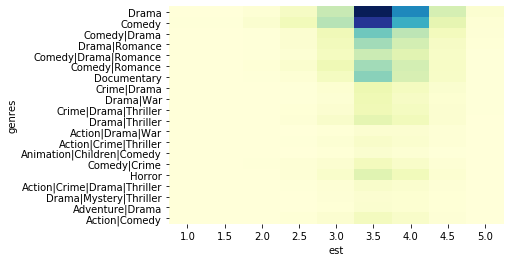

In [149]:
sns.heatmap( pd.crosstab(m_df.genres, m_df.est).sort_values(5.0, ascending = False).head(20),
            cmap="YlGnBu", cbar=False)

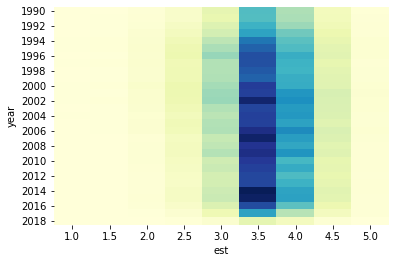

In [150]:
user_pred_df = pd.crosstab(m_df.year, m_df.est)
user_pred_df.sort_values(1.0, ascending = False).head()
sns.heatmap( user_pred_df.loc['1990':],   cmap="YlGnBu", cbar=False)

### grid search 

In [151]:
param_grid = {'k': [40, 100], 'min_k': [5, 10],}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

be = gs.best_estimator

print(be)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.9557842231875094
{'k': 40, 'min_k': 5}
{'rmse': <surprise.prediction_algorithms.knns.KNNBasic object at 0x1a4942df90>, 'ma

In [152]:
print(gs.best_params['mae'])


{'k': 40, 'min_k': 5}


#### Grid Search with different similarity measures .

We are using grid search algorithm to find optimized set of parameters 
for recommendation. 
We are using KNN based algorithm
parameters for this algo are :
* K :
* k (int) 
– The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
* min_k (int) 
– The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the neighbor aggregation is set to zero (so the prediction ends up being equivalent to the mean 𝜇𝑢 or 𝜇𝑖). Default is 1.
* sim_options 
these are options to optimize similarity measures. Following are the params in this dict. 

'name': The name of the similarity to use, as defined in the similarities module. Default is 'MSD'.
'user_based': Whether similarities will be computed between users or between items. This has a huge impact on the performance of a prediction algorithm. Default is True.
'min_support': The minimum number of common items (when 'user_based' is 'True') or minimum number of common users (when 'user_based' is 'False') for the similarity not to be zero. Simply put, if |𝐼𝑢𝑣|<min_support then sim(𝑢,𝑣)=0. The same goes for items.

We are doing 3 fold cross validation in following case by passing cv value as 3.


In [154]:
param_grid = {'k': [40, 100], 'min_k': [5, 10],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False, True]}}
gs_basic = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)
gs_basic.fit(data)
# best RMSE score
print(gs_basic.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_basic.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done c

In [155]:
gs.best_params['mae']

{'k': 40, 'min_k': 5}

In [156]:
param_grid = {'k': [40, 70, 100], 'min_k': [5, 10],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False, True]}}
gs_means = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
gs_means.fit(data)
print(gs_means.best_score['rmse'])
print(gs_means.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarit

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [ ]:
param_grid = {'k': [40, 70, 100], 'min_k': [5, 10],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False, True]},
             'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]}} 
'bls'
gs_baseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5)
gs_baseline.fit(data)
print(gs_baseline.best_score['rmse'])
print(gs_baseline.best_params['rmse'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases 

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine 

###  Deciding best estimator from 3 algorithms 

In [ ]:
best_score = gs_basic.best_score['rmse']
best_gs = gs_basic
for al in [gs_baseline, gs_means]:
    if al.best_score['rmse'] > best_score:
        best_gs = al
        best_score = al.best_score['rmse']


In [ ]:
best_algo = best_gs.best_estimator['rmse']
best_algo.fit(data.build_full_trainset())
pred_best_est = best_algo.test(anti_set)
accuracy.rmse(pred_best_est, verbose=True)
pred_best_df = pd.DataFrame(pred_best_est)
movies_rec_best = movies_df.merge(pred_best_df, left_on = 'movieId', right_on = 'iid')
movies_rec_best['est'] = movies_rec_best.est.apply(lambda x: (round(x*2))/2)

In [ ]:
# movies_rec_best is the prediction of movies using best algo Our further analysis will be on these predictions 


In [ ]:
user_best_pred_df = pd.crosstab(movies_rec_best.year, movies_rec_best.est)
sns.heatmap( user_best_pred_df.loc['1990':],  cbar=False, cmap="YlGnBu")

In [ ]:
movie_rat_uid_1=movie_rat_df[movie_rat_df.uid==1]
uid_1_actual_by_genre= pd.crosstab( movie_rat_uid_1.genres, movie_rat_uid_1.rating) 

sns.heatmap(uid_1_actual_by_genre.sort_values(5.0, ascending = False), cbar=False, cmap="YlGnBu")


In [ ]:
uid_1_best = movies_rec_best[movies_rec_best.uid==1]
uid_1_rat5_best = uid_1_best[uid_1_best.est==5.0]
sns.heatmap(pd.crosstab( uid_1_best.genres, uid_1_best.est).sort_values(5.0, ascending = False).head(20),
            cbar=False, cmap="YlGnBu")